# Three investigators - part II

A project for scraping and analysing data from a fan site on the audio book called '[The three investigators](https://en.wikipedia.org/wiki/Three_Investigators#Germany)'

Part II: Data preparation and explorative analysis

- additional data cleaning and preparing for analysis
- explorative analysis of data
- prediction of episode ratings

# Setup

In [1]:
#python version used for this project
from platform import python_version
print(python_version())

3.7.5


In [1]:
# import modules [as specified in requirements.txt]
import pandas as pd
import numpy as np
import re
import requests
from datetime import date
import matplotlib.pyplot as plt

# for file directories
import os

%matplotlib inline

In [2]:
#change directory to root folder
os.chdir("..")

# Load data

In [3]:
#load scraped datafiles
meta = pd.read_csv(".\\data\\scraped\\meta.csv")
actors = pd.read_csv(".\\data\\scraped\\actor_all.csv")
content = pd.read_csv(".\\data\\scraped\\content_all.csv")
rating = pd.read_csv(".\\data\\scraped\\rating.csv")

#load actor gender prediction
gender = pd.read_csv(".\\data\\processed\\actor_gender_prediction_2020-09-26.csv")

In [4]:
meta.shape

(205, 44)

# Data cleaning and prep

## Consistent column labels

In [5]:
# make all column names lower case
df_list = [meta, actors, content, rating]

for df in df_list:
    df.columns = df.columns.str.lower()

## add/remove episode 29 from tables

In [6]:
### add episode 29 details to meta table (https://www.rocky-beach.com/hoerspiel/folgen/029.html)
meta = meta.append({'id' : 29, 'music': 'B. Brac/B. George', 'date':'1982-03-21', 
                     'minutes': '34', 'minutes_mean':34, 'minutes_total':34, 'parts':1} , ignore_index=True)

## remove 29 from actors table
actors = actors.loc[actors["id"] != 29]

## Gender predictions

In [7]:
# join tables
actors = pd.merge(actors, gender, left_on='firstname', right_on = "name", how="left")
actors = actors.drop("name", axis=1)
actors.head()

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator,Unnamed: 0,gender,gender_probability,gender_count
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1,1,male,0.99,165452
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0,1,male,0.99,32776
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0,1,male,0.99,23807
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0,1,male,0.99,71365
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0,1,male,0.99,101928


In [8]:
# get list of names that have not been classified with a gender
actors.loc[actors["gender"].isna()]["firstname"].unique()

array(['Heikedine', 'Reinhilt', 'J.S.', 'H.', 'Schiffmeister', '...',
       'Rosakutty', 'Gustav-Adolph', 'Rhesi', 'é', 'Jörgpeter'],
      dtype=object)

In [9]:
## classify gender of missing ones (if known)
actors.loc[actors["firstname"] == 'Heikedine', "gender"] = "female"
actors.loc[actors["firstname"] == 'Reinhilt', "gender"] = "female"
actors.loc[actors["firstname"] == 'Gustav-Adolph', "gender"] = "male"
actors.loc[actors["firstname"] == 'Jörgpeter', "gender"] = "male"
actors.loc[actors["firstname"] == 'Rhesi', "gender"] = "female"
actors.loc[actors["firstname"] == 'é', "gender"] = "male"

## Add to meta data

In [10]:
## Create year and month column
meta["year"] = pd.DatetimeIndex(meta["date"]).year
meta["month"] = pd.DatetimeIndex(meta["date"]).month

### Number of actors, main and side

In [11]:
actors_agg = pd.DataFrame(actors.groupby("id")[["actor", "main_actor", "narrator"]].agg(
    {"actor": "count", "main_actor":"sum", "narrator": "max"})).reset_index()
actors_agg = actors_agg.rename(columns={"actor":"no_actors_total", "main_actor":"no_main_actors"})
actors_agg["no_side_actors"] = actors_agg["no_actors_total"] - actors_agg["no_main_actors"] - actors_agg["narrator"] #also remove narrator

#join with meta
meta = pd.merge(meta, actors_agg, left_on="id" ,right_on="id", how='left')

### Gender balance all actors

In [12]:
actors_gender = actors.groupby(["id", "gender"])["role"].count()
actors_gender = pd.DataFrame(actors_gender).unstack().fillna(0).reset_index("id")
actors_gender.columns = actors_gender.columns.droplevel(level=0)
actors_gender = actors_gender.rename(columns={"": "id", "female": "no_female_actors", "male": "no_male_actors"})

#join with meta
meta = pd.merge(meta, actors_gender, left_on="id" ,right_on="id", how='left')

#gender missing
meta["no_actor_gender_missing"] = meta["no_actors_total"] - meta[["no_female_actors", "no_male_actors"]].sum(axis=1)

#gender balance for all actors
meta["female_actors_ratio"] = meta["no_female_actors"] / meta[["no_female_actors", "no_male_actors"]].sum(axis=1) *100

### Gender balance side actors

In [13]:
filter_side_actors = (actors["narrator"] == 0) & (actors["main_actor"] == 0)
side_actors_gender = actors.loc[filter_side_actors].groupby(["id", "gender"])["role"].count()
side_actors_gender = pd.DataFrame(side_actors_gender).unstack().fillna(0).reset_index("id")
side_actors_gender.columns = side_actors_gender.columns.droplevel(level=0)
side_actors_gender = side_actors_gender.rename(columns={"": "id", "female": "no_female_side_actors", "male": "no_male_side_actors"})

#join with meta
meta = pd.merge(meta, side_actors_gender, left_on="id" ,right_on="id", how='left')

#gender balance for side actors
meta["female_side_actors_ratio"] = meta["no_female_side_actors"] / meta[["no_female_side_actors", "no_male_side_actors"]].sum(axis=1) *100

### Narrator

In [14]:
narrator = actors.loc[actors["narrator"]==1][["id","actor_clean"]]
narrator = narrator.rename(columns={"actor_clean": "narrator_name"})

#join with meta
meta = pd.merge(meta, narrator, left_on="id" ,right_on="id", how='left')

### Author

In [15]:
#replace 'Erzählt von Kari Erlhoff' with 'Kari Erlhoff'
meta["erzählt von"] = meta["erzählt von"].str.replace('Erzählt von Kari Erlhoff', 'Kari Erlhoff')

In [16]:
# group authors
meta["author_grouped"] = meta["erzählt von"]

# group those authors with fewer than 5 episodes under 'other'
other_storytellers = pd.DataFrame(meta["erzählt von"].value_counts()).reset_index()
other_storytellers = other_storytellers.loc[other_storytellers["erzählt von"] < 5]["index"].tolist()
meta.loc[meta["erzählt von"].isin(other_storytellers), "author_grouped"] = "Other"

#display values
meta["author_grouped"].value_counts()

André Marx                           33
Marco Sonnleitner                    32
Ben Nevis                            21
Other                                18
Brigitte Johanna Henkel-Waidhofer    16
M.V. Carey                           15
William Arden                        14
Kari Erlhoff                         13
André Minninger                      12
Robert Arthur                        10
Astrid Vollenbruch                    9
Christoph Dittert                     7
Hendrik Buchna                        6
Name: author_grouped, dtype: int64

In [17]:
# create gender variable
author_gender_map = {'Robert Arthur': "male", 'William Arden': "male", 'M.V. Carey':"female",
                     'Nick West':"male", 'Marc Brandel':"male", 'Rose Estes':"female", 
                     'Megan Stine / H. William Stine': np.nan,
                   'G.H. Stone':"female", 'William McCay' : "male", 'Peter Lerangis' : "male",
                   'Brigitte Johanna Henkel-Waidhofer' : "female", 'André Marx' : "male",
                    'André Minninger' : "male", 'Ben Nevis': "male", 'Katharina Fischer': "female",
                   'Marco Sonnleitner' :"male", 'Astrid Vollenbruch': "female", 'Kari Erlhoff' : "female",
                  'Hendrik Buchna': "male", 'Christoph Dittert':"male"}

meta["author_gender"] = meta["erzählt von"].map(author_gender_map)

### merge rating

In [19]:
#rename columns in rating table
rating = rating.rename(columns={"bewertung.1" : "rating", "rang": "rating_rank", "ranking": "no_votes"})

#join with meta table
meta = pd.merge(meta, rating, left_on="id" ,right_on="id", how='left')

### content

In [23]:
meta["titel"].unique()

array(['Der Super-Papagei (Hörspiel)', 'Der Phantomsee (Hörspiel)',
       'Der Karpatenhund (Hörspiel)', 'Die schwarze Katze (Hörspiel)',
       'Der Fluch des Rubins (Hörspiel)',
       'Der sprechende Totenkopf (Hörspiel)',
       'Der unheimliche Drache (Hörspiel)', 'Der grüne Geist (Hörspiel)',
       'Die rätselhaften Bilder (Hörspiel)',
       'Die flüsternde Mumie (Hörspiel)',
       'Das Gespensterschloß (Hörspiel)',
       'Der seltsame Wecker (Hörspiel)',
       'Der lachende Schatten (Hörspiel)', 'Das Bergmonster (Hörspiel)',
       'Der rasende Löwe (Hörspiel)', 'Der Zauberspiegel (Hörspiel)',
       'Die gefährliche Erbschaft (Hörspiel)',
       'Die Geisterinsel (Hörspiel)', 'Der Teufelsberg (Hörspiel)',
       'Die flammende Spur (Hörspiel)', 'Der tanzende Teufel (Hörspiel)',
       'Der verschwundene Schatz (Hörspiel)',
       'Das Aztekenschwert (Hörspiel)', 'Die silberne Spinne (Hörspiel)',
       'Die singende Schlange (Hörspiel)', 'Die Silbermine (Hörspiel)',
     

In [ ]:
df.loc[:, "recipientOrgType"] = None

tests = [
         [r'\b(ltd|limited)$', 'Company/Mutual Society: Company - Limited by Guarantee'],
         [r'(primary|secondary|junior|high|community|comprehensive|infants?|girls|boys|middle|grammar|c of e|village|first) (school|academy)|community college|(6th|sixth) form|school academy', 'School: State School'],
         [r'\b(friends of.*school|p ?t ?f? ?a|parent teacher|out of school club|after school)\b', 'School support'],
         [r'^(the )?[a-z]+ (school|academy)$', 'School: State School'],
         [r'(pre ?|nursery )school|day nursery', 'Charity: Preschool'],
         [r'play ?group', 'Charity: Playgroup'],
         [r'\b(guide (association|unit)|guides|scouts|scout (group|unit)|rainbows|brownies|cubs|(boys|girls) brigade|air training corps|cadets?|c ?c ?f)\b', 'Charity: Uniform'],
         [r'(county|borough|district|city) council', 'Public Sector: Local Authority'],
         [r'^[a-z]+ council$', 'Public Sector: Local Authority'],
         [r'combined authority$', 'Public Sector: Local Authority'],
         [r'^(lb|london borough of) ', "Public Sector: Local Authority"],
         [r'(\byouth offending team\b|\by ?o ?t$) ', "Public Sector: Local Authority"],
         [r'(town|parish|community) council', 'Public Sector: Parish Council'],
         [r'\bchurch$', 'Other: Church-based faith organisation'],
         [r'\b(parochial church council|p ?c ?c)\b', 'Other: Parochial Church Council'],
         [r'(village|parish|memorial|church) hall', 'Charity: Village Hall'],
         [r'(football|rugby( league| union)?|volleyball|rowing|canoe|yacht|kayak(ing)?|croquet|angling|fishing|swimming|sports|basketball|athletics?|pistol|gymnastics?|golf|cricket|netball|tennis|sailing|bowling|bowls|boxing|badminton|hockey) club', 'Sports club'],
         [r'\b(ru?)?fc\b|sports council', 'Sports club'],
         [r'university(?!.*third age)', 'University'],
         [r'(imperial|kings) college|school of.*tropical medicine', 'University'],
         [r"\b(co-?operative)\b", 'Company/Mutual Society: Co-operative Society'],
         [r"\b(cic|c i c|community interest company)\b", 'Company/Mutual Society: CIC'],
         [r'this is a programme for individual veterans as opposed to organisaitons|individual recipient|no organisation', 'Other: Individual'],
         [r'residents (association|action committee)', 'Charity: Residents association'],
         [r'\b(british legion|forces association)\b', 'Charity: Forces association'],
         [r'\byouth club\b', 'Charity: Youth Club'],
         [r'\bcredit union\b', 'Company/Mutual Society: Credit Union'],
         [r'\bfriendly society\b', 'Company/Mutual Society: Friendly Society'],
         [r'\bn ?h ?s ?\b', 'Public Sector: NHS'],
         [r'(\bparochial church council\b|\bp ?c ?c ?$)', 'Other: Parochial Church Council'],
         [r'\b(community (group|association|centre))', 'Charity: Community Group'],
         [r'u3a|university.*third age|citizens advice|\bage (uk|concern)\b|voluntary action|womens institute|groundwork|y ?(m|w) ?c ?a|homestart|dial a ride|carers trust|law centre|council for voluntary service', 'Charity: Registered Charity'],
]

for r, t in tests:
  df.loc[df.recipientName.str.contains(r), "recipientOrgType"] = t

df.loc[
    df.recipientIDPrefix.isin(['GB-CHC','GB-SC','GB-NIC']) &
    df['recipientOrgType'].isnull(),
    "recipientOrgType"
] = 'Charity: Registered Charity'
df.loc[:, 'recipientOrgType'] = df['recipientOrgType'].fillna(df['recipientOrganization.0.organisationType'])

df.loc[df.index.str.startswith('360G-SE-'), 'recipientOrgType'] = 'Sports club'

pd.crosstab(
    df['recipientOrgType'].fillna("[missing]"),
    [
        (df['fundingOrganization.0.id']=='GB-GOR-PB188').rename('is_nlcf').apply(lambda x: 'NLCF' if x else 'Other funder'), 
        (df['recipientIDPrefix']=='360G').rename('missing_orgid')
    ],
    margins=True
).drop('All').sort_values("All", ascending=False)





# Explorative Analysis

## Chronology

In [16]:
years = meta.groupby("year")[["parts", "minutes_mean", "id"]].agg({
    "parts": ["sum"], "minutes_mean" : ["mean", "min", "max"], "id": ["count","min", "max"]})
years.columns = ["_".join(x) for x in years.columns.ravel()]
years = years.reset_index().rename(columns={"minutes_mean_mean": "minutes_mean",
                              "minutes_mean_min": "minutes_min", "minutes_mean_max":"minutes_max"}) 
years.head()

,year,parts_sum,minutes_mean,minutes_min,minutes_max,id_count,id_min,id_max
0,1979,9,45.555556,43.0,50.0,9,1,9
1,1980,12,42.416667,38.0,49.0,12,10,21
2,1981,6,43.666667,41.0,49.0,6,22,27
3,1982,3,39.333333,34.0,44.0,3,28,30
4,1983,3,43.666667,40.0,49.0,3,31,33


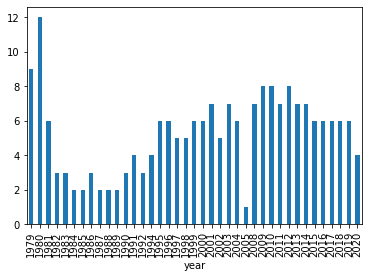

In [28]:
#number of episodes over time
years.set_index("year")["id_count"].plot(kind='bar')

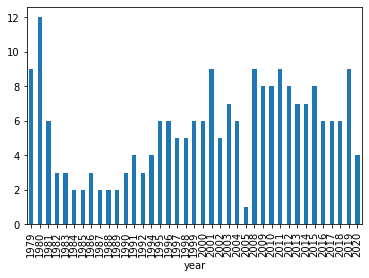

In [29]:
#number of episodes over time
years.set_index("year")["parts_sum"].plot(kind='bar')

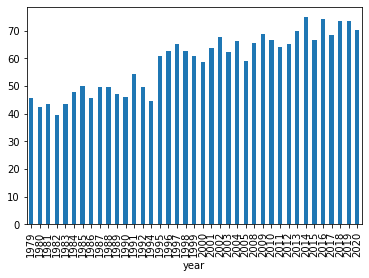

In [30]:
#Average length over time
years.set_index("year")["minutes_mean"].plot(kind='bar')

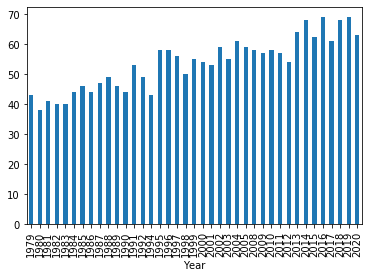

In [29]:
#Average length over time
years.set_index("year")["minutes_min"].plot(kind='bar')

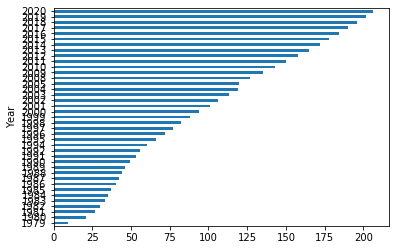

In [37]:
#number of episodes over time
years.set_index("year")["id_max"].plot(kind='barh')

## Author

In [24]:
meta["minutes_mean"].dtype

dtype('float64')

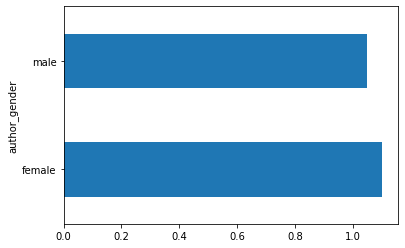

In [85]:
meta.groupby("author_gender")["parts"].mean().plot(kind='barh')

## Gender

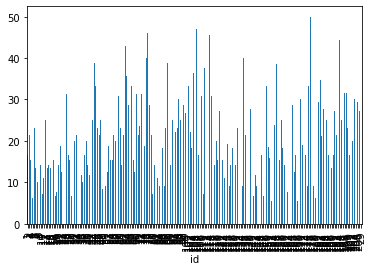

In [34]:
#number of episodes over time
meta.set_index("id")["female_actors_ratio"].plot(kind='bar')

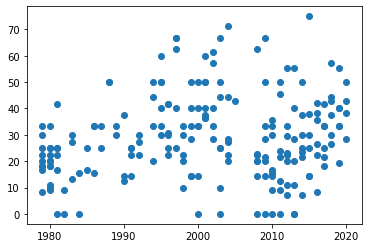

In [41]:
x = meta["year"]
y = meta["female_side_actors_ratio"]

plt.scatter(x, y)

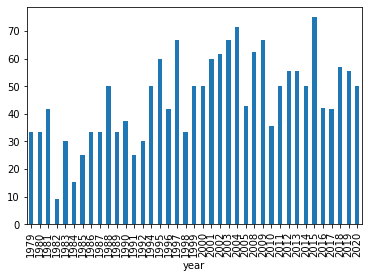

In [46]:
meta.groupby("year")["female_side_actors_ratio"].max().plot(kind='bar')

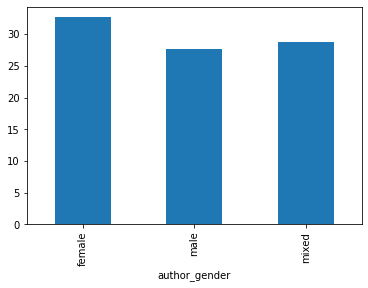

In [74]:
meta.groupby("author_gender")["female_side_actors_ratio"].mean().plot(kind='bar')

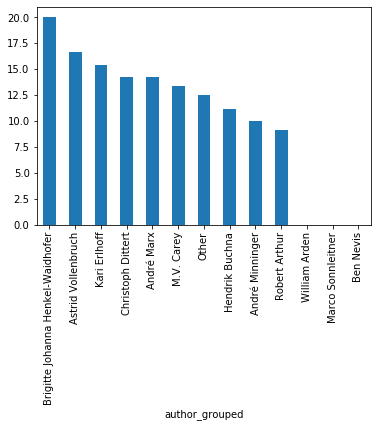

In [80]:
meta.groupby("author_grouped")["female_side_actors_ratio"].min().sort_values(ascending=False).plot(kind='bar')

## Rating

In [49]:
rating.columns

Index(['episode', 'bewertung.1', 'rang', 'ranking', 'id', 'source'], dtype='object')

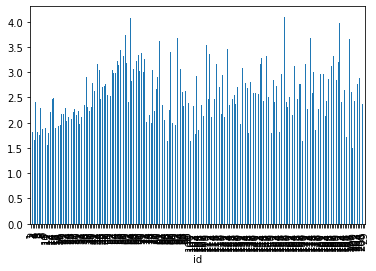

In [58]:
#number of episodes over time
meta.set_index("id")["rating"].plot(kind='bar')

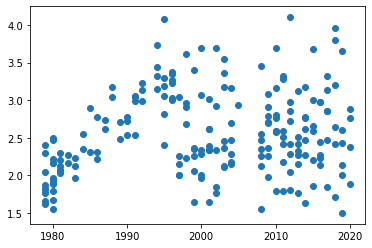

In [59]:
x = meta["year"]
y = meta["rating"]

plt.scatter(x, y)

ValueError: too many values to unpack (expected 2)

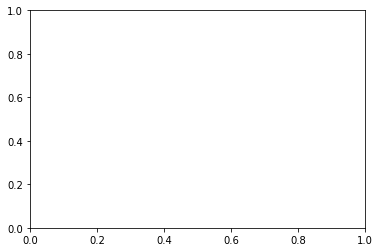

In [104]:
x = meta["year"]
y = meta["rating"]
z= meta["narrator_name"]

data = (x, y, z)
colors = ("red", "green", "blue", "black")
groups = ("coffee", "tea", "water", "mouse")


# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Matplot scatter plot')
plt.legend(loc=2)
plt.show()

In [102]:
meta.shape

(208, 63)

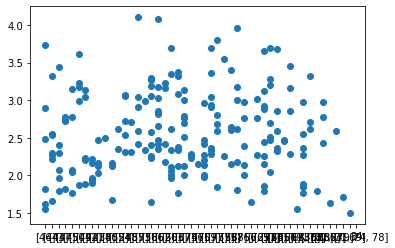

In [82]:
x = meta["minutes"]
y = meta["rating"]

plt.scatter(x, y)

In [108]:
meta.columns

Index(['id', '"anudhara" aufgenommen bei bantree records, worms / produzent',
       'buch', 'buch und effekte', 'buch und redaktion', 'cover-illustration',
       'coverillustration', 'design', 'effekte und redaktion',
       'erscheinungsdatum', 'erzählt von', 'geräusche', 'ger�usche',
       'hörspielbearbeitung', 'klang-recycling', 'laufzeit', 'musik',
       'musik und effekte',
       'nessie der seltsame wecker matthias green recyclings aus 3 fragezeichen rap',
       'produktion und regie', 'projektleitung und produktmanagement',
       'redaktion', 'redaktion und geräusche', 'regie', 'regie und produktion',
       'song', 'teil a erzählt von', 'teil b erzählt von',
       'teil c erzählt von', 'titel', 'titelmusik', 'html',
       'zur vorherigen folge | zur nächsten folge', 'book', 'cover', 'music',
       'director', 'editor', 'sounds', 'date', 'minutes', 'minutes_mean',
       'minutes_total', 'parts', 'year', 'month', 'no_actors_total',
       'no_main_actors', 'narrator',

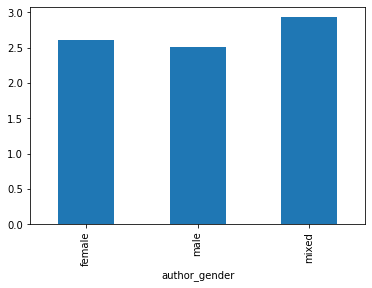

In [72]:

meta.groupby("author_gender")["rating"].mean().plot(kind='bar')

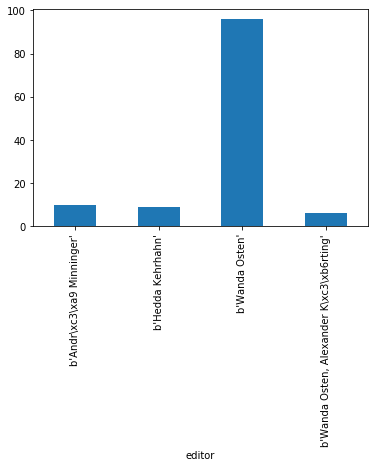

In [112]:
meta.groupby("editor")["rating"].count().plot(kind='bar')

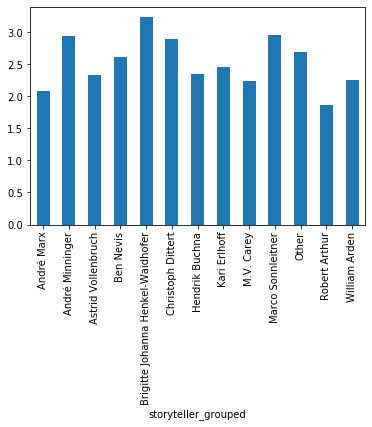

In [43]:
meta.groupby("storyteller_grouped")["rating"].mean().plot(kind='bar')

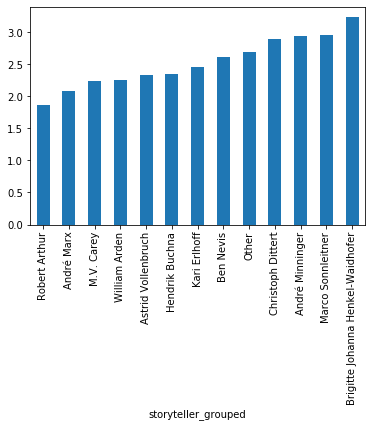

In [60]:
meta.groupby("storyteller_grouped")["rating"].mean().sort_values().plot(kind='bar')

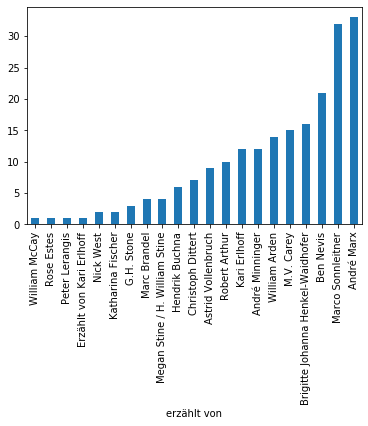

In [121]:
meta.groupby("erzählt von")["rating"].count().sort_values().plot(kind='bar')

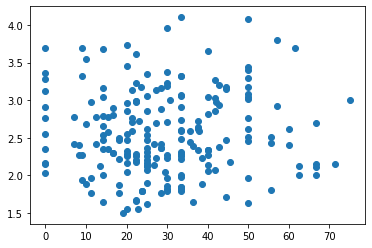

In [125]:
x = meta["female_side_actors_ratio"]
y = meta["rating"]

plt.scatter(x, y)

In [103]:
meta["narrator"]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
203    1.0
204    1.0
205    1.0
206    1.0
207    NaN
Name: narrator, Length: 208, dtype: float64